## Final Project 1 Jupyter Notebook: 1994 Rwandan Genocide

### Group 4: John Graunt

Authors: Vishali Vallioor, Shannon Ling, Kevin Kim, Samantha Wu, Isao Hayashi

In this Jupyter Notebook, we'll be introducing population functions, population pyramid functions and more in order to quantify the 1994 Rwandan Genocide using data analysis. We primarily utilize the WBData Population dataset in order to compile data containing population for each age, gender, year, and country. We cite the information from WB Data. [https://wbdata.readthedocs.io](https://wbdata.readthedocs.io). We primarily aim to analyze the 1994 Rwandan Genocide using graphs and visualizations.

## Table of Contents

- [Introduction & Imports](#intro)
- [Population Function, <span style="color: red;">*Deliverable 1[A] - Population Statistics*</span>](#population-f)
- [Population DataFrame Function, <span style="color: red;">*Deliverable 3[A] - Population DataFrames*</span>](#population-df)
- [Regular Population Pyramids, <span style="color: red;">*Deliverable 4[B] - Population Pyramids*</span>](#regular-pyramid)
- [Animated Population Pyramids, <span style="color: red;">*Deliverable 5[C] - Animated Population Pyramids*</span>](#animated)
- [Visualizations, <span style="color: red;">*Deliverable 7[C] - Other Visualization Tools*</span>](#graphs)
    - [Total Population](#total-population)
    - [Population by Gender](#popl-by-gender)
    - [Population by Gender in Percent](#popl-by-gender-in-percent)
    - [Mortality Rate per 1000 Adults](#mortality-rate-for-1000-adults)
    - [Crude Death Rate per 1000 People](#crude-death-rate-per-1000-people)
    - [Net Migration in Rwanda](#net-migration-in-rwanda)
    - [Net Migration in Rwanda and Neighboring Countries](#net-migration-in-rwanda-and-neighboring-countries)
    - [Net Migration in Neighboring Countries as a Percentage of Total Population](#net-migration-in-neighboring-countries)
    - [Life Expectancy at Birth](#life-expectancy-at-birth)
    - [GDP Per Capita](#gdp-per-capita)
    - [Agriculture Productivity](#agriculture-productivity)
- [Unit Tests, <span style="color: red;">*Deliverable 2[A] - Unit Tests*</span>](#unit-tests)


## Introduction & Imports <a name="intro"></a>
This section contains all of our necessary imports and pip installs for the rest of this Jupyter notebook. 

In [2]:
!pip install wbdata

import wbdata

import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import re

!pip install cufflinks
import cufflinks as cf
cf.go_offline()

## Population Function, *Deliverable 1[A] - Population Statistics* <a name="population-f"></a>
In this section, we define our population function. It first creates a dictionary that maps all of the possible country names to their respective 3 letter country code. Then, once we do that, we calculate the population for specific ages by dividing 5-length age ranges by 5, then calculate the desired age range's population based on the user's entry, for the specified country and gender.

In [25]:
countries = wbdata.get_countries()
country_dict = {}

# Iterate over the WBSearchResult object, Create Dictionary.
# This dictionary is necessary so that we know which country
# names map to which 3-letter country codes.
for country in countries:
    country_code = country['id']
    country_name = country['name']

    # Add to the dictionary the country name.
    country_dict[country_name] = country_code

def int_to_str(num):
    """Convert the integer to the proper format."""
    if 0 <= num < 10:
        # Add a '0' prefix if it is a single digit.
        return f"0{num}"
    else:
        # Convert to string directly if it is a two-digit number.
        return str(num)

def population_range(year, sex, age_range, place):
    """This function will return the population for a certain age range."""
    sex_codes = {"people": "", "females": "FE", "males": "MA"}
    sex_used = sex_codes[sex]

    # Getting the lower and upper bounds for date into correct format.
    lower, upper = int_to_str(age_range[0]), int_to_str(age_range[1])
    range_string = lower + upper

    # Getting the country code via the name.
    country_code = country_dict.get(place)

    df = wbdata.get_dataframe({"SP.POP." + range_string + "." + sex_used: "Population"},
                              country= {country_code: place}).squeeze()
    df = df.to_frame().reset_index()
    population_total = int(df[df["date"] == str(year)]["Population"])
    return population_total

def dict_helper(year, sex, age_range, place):
    """This will expand our function to include every age specified possible."""
    if len(age_range) == 1:
        age_range = [age_range[0], age_range[0]]
    elif age_range[1] < age_range[0]:
      raise ValueError(f"Please ensure that the second value in the range is greater than the first.")

    minimum_age, maximum_age = age_range
    possible_minimums = [i for i in range(0, 76, 5)]
    possible_maximums = [i for i in range(4, 80, 5)]

    my_dict = {}
    for age in range(minimum_age, maximum_age + 1):
        """Find the index in the possible ranges that includes the current age."""
        range_index = next((i for i, min_val in enumerate(possible_minimums) if
                            min_val <= age and age <= possible_maximums[i]), None)
        if range_index is not None:
            popl_value = population_range(year, sex, [possible_minimums[range_index], possible_maximums[range_index]], place) // 5
            my_dict[age] = popl_value
        else:
            raise ValueError(f"No age range available for age {age}")

    return my_dict


def population(year, sex, age_range, place):
    """This function ties everything together, returning population for given age ranges.
    During usage, please utilize the following format:
    Arguments to Use:
    Year (int): the specified year, works from 1960-2021.
    Sex (string): Anything from all, people, p, P, People, All, Everyone, female, females, f, Female, 
                Females, F, FE, male, males, m, Male, Males, M, MA works.
    Age Range (list with length 2, 2 integers): A list of the age bounds.
    Place (string): A string of the specified location.
    """
    if place not in country_dict:
        valid_regions = ", ".join(country_dict.keys())
        raise ValueError(f"The region '{place}' is not valid. Please choose from the following regions: {valid_regions}")
    if sex in ["all", "people", "p", "P", "People", "All", "Everyone"]:
      female_dict = dict_helper(year, "females", age_range, place)
      male_dict = dict_helper(year, "males", age_range, place)
      return sum(female_dict.values()) + sum(male_dict.values())
    elif sex in ["female", "females", "f", "Female", "Females", "F", "FE"]:
      female_dict = dict_helper(year, "females", age_range, place)
      return sum(female_dict.values())
    elif sex in ["male", "males", "m", "Male", "Males", "M", "MA"]:
      male_dict = dict_helper(year, "males", age_range, place)
      return sum(male_dict.values())

## Population DataFrame Function <a name="population-df"></a>
In this section, we extend our population function to be able to create a dataframe containing the population across multiple ages, multiple years, and multiple countries. Keep in mind that year would be formatted like [2010, 2011, 2012] whereas age would be formatted like [10, 20] where it would include all ages from 10 to 20, but the year would solely include the years within the list. It will return a data frame indexed by Region and Year. 

In [26]:
def create_population_dataframe(regions, years, age_range):
    """Creates the population DataFrame based on the regions, years, and age ranges wanted.
    During usage, please utilize the following format:
    Arguments to Use:
    regions (list of strings, any length): the specified year, works from 1960-2021.
    years (list of ints, any length): Anything from all, people, p, P, People, All, Everyone, female, females, f, Female, 
                Females, F, FE, male, males, m, Male, Males, M, MA works.
    age_range (list of two ints): the age bounds specified, second must be greater than the first.
    """
    data = []

    # Check if age_range is a single age or a range.
    if len(age_range) == 1:
        full_age_range = [age_range[0]]
    else:
        full_age_range = list(range(age_range[0], age_range[1] + 1))

    # Iterate over each region, year, and age."
    for region in regions:
        for year in years:
            row = {'Region': region, 'Year': year}
            for age in full_age_range:
                male_population = population(year, 'male', [age], region)
                female_population = population(year, 'female', [age], region)
                total_population = male_population + female_population

                row[f'Male Population Age {age}'] = male_population
                row[f'Female Population Age {age}'] = female_population
                row[f'Total Population Age {age}'] = total_population

            data.append(row)

    # Create a DataFrame.
    df = pd.DataFrame(data)

    # Set the index.
    df.set_index(['Region', 'Year'], inplace=True)

    return df

In [27]:
population_df = create_population_dataframe(["Rwanda"], [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000], [5, 70])
population_df

Male Population Age 5  Female Population Age 5  \
Region Year                                                   
Rwanda 1990                 121011                   121328   
       1991                 124404                   124623   
       1992                 127175                   127331   
       1993                 130735                   130878   
       1994                 114503                   114640   
       1995                 100162                   100289   
       1996                 115815                   115961   
       1997                 128769                   128924   
       1998                 127215                   127658   
       1999                 121429                   122414   
       2000                 116750                   118170   

             Total Population Age 5  Male Population Age 6  \
Region Year                                                  
Rwanda 1990                  242339                 121011   
       1991                  249027                 124404   
       1992                  254506                 127175   
       1993                  261613                 130735   
       1994                  229143                 114503   
       1995                  200451                 100162   
       1996                  231776                 115815   
       1997                  257693                 128769   
       1998                  254873                 127215   
       1999                  243843                 121429   
       2000                  234920                 116750   

             Female Population Age 6  Total Population Age 6  \
Region Year                                                    
Rwanda 1990                   121328                  242339   
       1991                   124623                  249027   
       1992                   127331                  254506   
       1993                   130878                  261613   
       1994                   114640                  229143   
       1995                   100289                  200451   
       1996                   115961                  231776   
       1997                   128924                  257693   
       1998                   127658                  254873   
       1999                   122414                  243843   
       2000                   118170                  234920   

             Male Population Age 7  Female Population Age 7  \
Region Year                                                   
Rwanda 1990                 121011                   121328   
       1991                 124404                   124623   
       1992                 127175                   127331   
       1993                 130735                   130878   
       1994                 114503                   114640   
       1995                 100162                   100289   
       1996                 115815                   115961   
       1997                 128769                   128924   
       1998                 127215                   127658   
       1999                 121429                   122414   
       2000                 116750                   118170   

             Total Population Age 7  Male Population Age 8  ...  \
Region Year                                                 ...   
Rwanda 1990                  242339                 121011  ...   
       1991                  249027                 124404  ...   
       1992                  254506                 127175  ...   
       1993                  261613                 130735  ...   
       1994                  229143                 114503  ...   
       1995                  200451                 100162  ...   
       1996                  231776                 115815  ...   
       1997                  257693                 128769  ...   
       1998                  254873                 127215  ...

## Regular Population Pyramids <a name="regular-pyramid"></a>
Next, we create a regular population pyramid for a singular specified year.

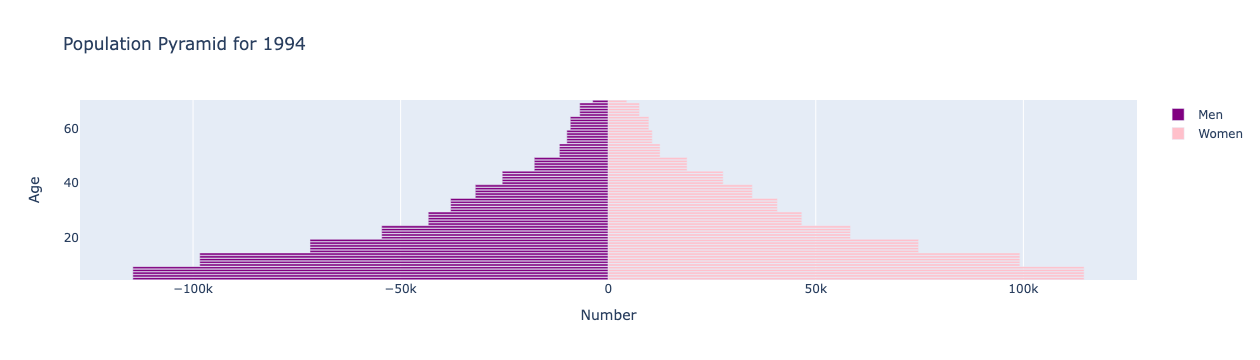

In [28]:
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd

py.init_notebook_mode(connected=True)

def plot_population_pyramid(df, year):
    """Plots the population pyramid given a working DataFrame from the 
    population dataframe function and a year."""

    # Filter the DataFrame for the given year and reset index.
    year_df = df[df.index.get_level_values('Year') == year].reset_index()

    # Aggregate data if there are multiple regions.
    year_df = year_df.groupby('Year').sum()

    # Extract age groups from column names.
    age_groups = sorted(set(int(col.split()[-1]) for col in year_df.columns if col.startswith('Male')))

    # Prepare data for plotting
    male_counts = [-year_df[f'Male Population Age {age}'].values[0] for age in age_groups]  # Negative for left side
    female_counts = [year_df[f'Female Population Age {age}'].values[0] for age in age_groups]

    # Create the plot.
    layout = go.Layout(barmode='overlay',
                       title=f'Population Pyramid for {year}',
                       yaxis=go.layout.YAxis(title='Age'),
                       xaxis=go.layout.XAxis(title='Number'))

    bins = [go.Bar(x=male_counts,
                   y=age_groups,
                   orientation='h',
                   name='Men',
                   marker=dict(color='purple'),
                   hoverinfo='skip'),
            go.Bar(x=female_counts,
                   y=age_groups,
                   orientation='h',
                   name='Women',
                   marker=dict(color='pink'),
                   hoverinfo='skip')]

    py.iplot(dict(data=bins, layout=layout))

# Example usage.
plot_population_pyramid(population_df, 1994)

## Animated Population Pyramids <a name="animated"></a>
To continue, we create an animated population pyramid which has a slider that changes based on the year. Note the slider will only work if there is more than 1 year specified in the population DataFrame, and the years will be based on this DataFrame as well.

In [29]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import re

def extract_ages(column_names):
    """Extract unique age values from column names using regular expression."""
    age_pattern = re.compile(r'Age (\d+)')
    ages = sorted(set(
        int(age_pattern.search(name).group(1))
        for name in column_names
        if age_pattern.search(name)
    ))
    return ages

def create_population_pyramid(dataframe, year_level='Year'):
    """Create an interactive population pyramid visualization for a given DataFrame."""

    def helper(year):
        # Filter dataframe for the selected year
        df_year = dataframe.xs(year, level=year_level)
        
        # Extract unique ages from column names and ensure they are sorted
        ages = extract_ages(dataframe.columns)
        
        # Prepare data for visualization
        data = []
        age_categories = []  # List to hold age categories in sorted order
        for age in ages:
            male_col = f'Male Population Age {age}'
            female_col = f'Female Population Age {age}'
            male_population = df_year[male_col].sum() if male_col in df_year else 0
            female_population = df_year[female_col].sum() if female_col in df_year else 0
            age_label = f'Age {age}'
            age_categories.append(age_label)
            
            data.append(go.Bar(name=f'Men {age_label}', x=[male_population], y=[age_label], orientation='h', marker=dict(color='blue')))
            data.append(go.Bar(name=f'Women {age_label}', x=[-female_population], y=[age_label], orientation='h', marker=dict(color='pink')))
        
        # Define layout with explicit y-axis category order
        layout = go.Layout(
            title=f'Population Pyramid for {year}', 
            barmode='overlay', 
            xaxis_title='Population', 
            yaxis_title='Age',
            yaxis=dict(categoryorder='array', categoryarray=age_categories)
        )
        
        # Create and display figure
        fig = go.Figure(data=data, layout=layout)
        fig.show()

    # Create and display the year slider widget
    min_year = dataframe.index.get_level_values(year_level).min()
    max_year = dataframe.index.get_level_values(year_level).max()
    year_slider = widgets.IntSlider(value=min_year, min=min_year, max=max_year, step=1, description='Year:', continuous_update=False)
    display(widgets.interactive(helper, year=year_slider))

create_population_pyramid(population_df)

interactive(children=(IntSlider(value=1990, continuous_update=False, description='Year:', max=2000, min=1990),…


## Visualizations <a name="graphs"></a>
In this section, we create different visualizations from the WBData dataset, based on DataFrames and other data structures. 

#### Total Population <a name="total-population"></a>

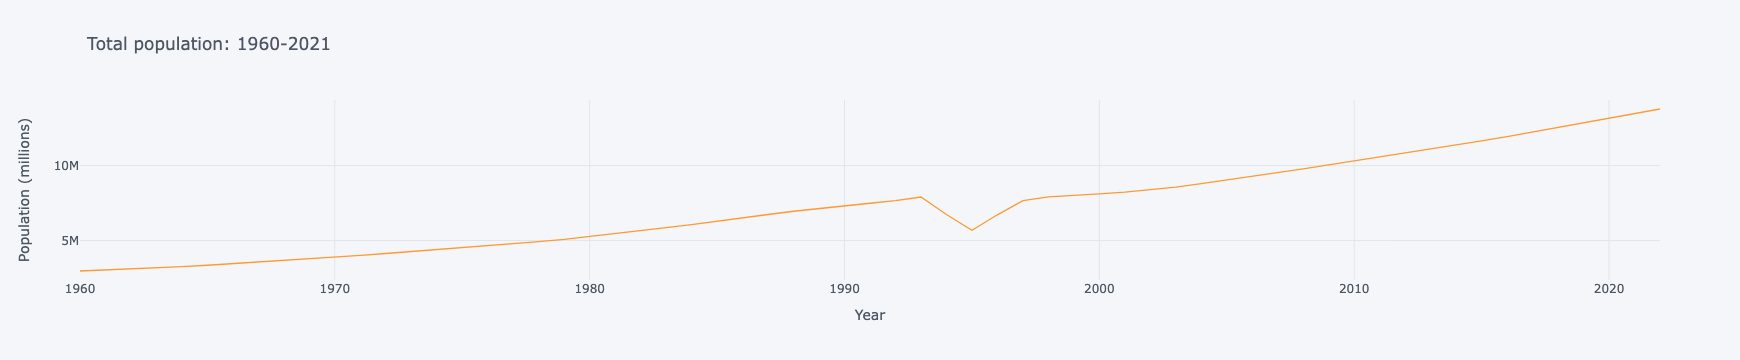

In [49]:
# Shows the total population over time.

# One variable: Total population
variable_labels = {"SP.POP.TOTL":"Rwandan Population"}

# Set country to Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
rwanda = wbdata.get_dataframe(variable_labels, country="RWA")

# Date index is of type string; change to integers
rwanda.index = rwanda.index.astype(int)

# Print graph from 1960-2022.
rwanda.iplot(title="Total population: 1960-2021",xTitle='Year',yTitle='Population (millions)')

#### Population by Gender <a name="popl-by-gender"></a>

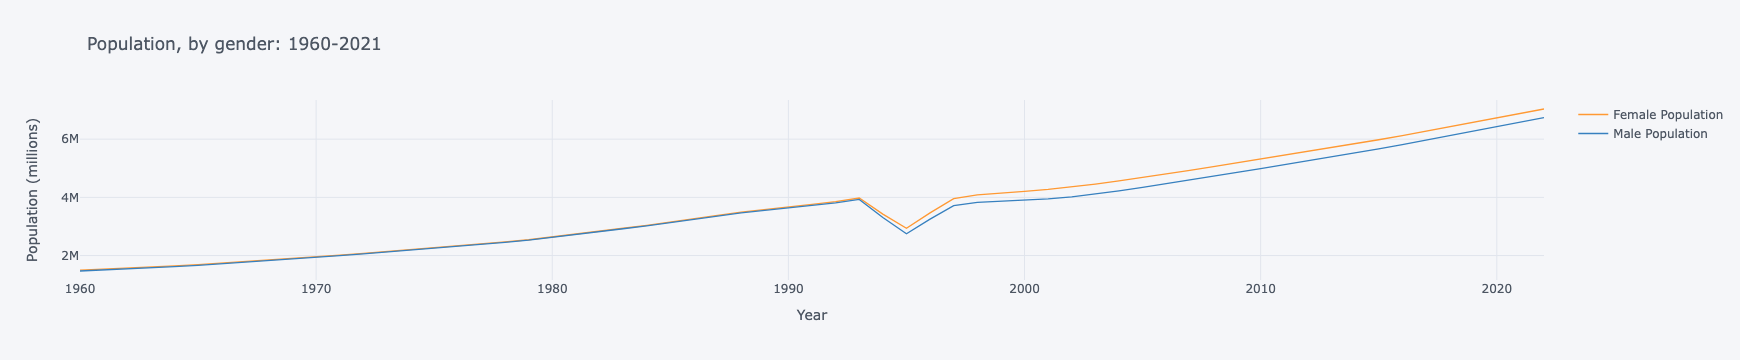

In [55]:
# Total population over time, with male and female.

# Three variables: Total Population, Total Female Population, Total Male Population
variable_labels = {"SP.POP.TOTL.FE.IN": "Female Population",
                   "SP.POP.TOTL.MA.IN": "Male Population"}

# Set country to Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
rwanda_pop = wbdata.get_dataframe(variable_labels, country = Rwanda).squeeze()

# Date index is of type string; change to integers
rwanda_pop.index = rwanda_pop.index.astype(int)

# Print graph from 1960-2022
rwanda_pop.iplot(title="Population, by gender: 1960-2021",xTitle='Year',yTitle='Population (millions)')

#### Population by Gender in Percent <a name="popl-by-gender-in-percent"></a>

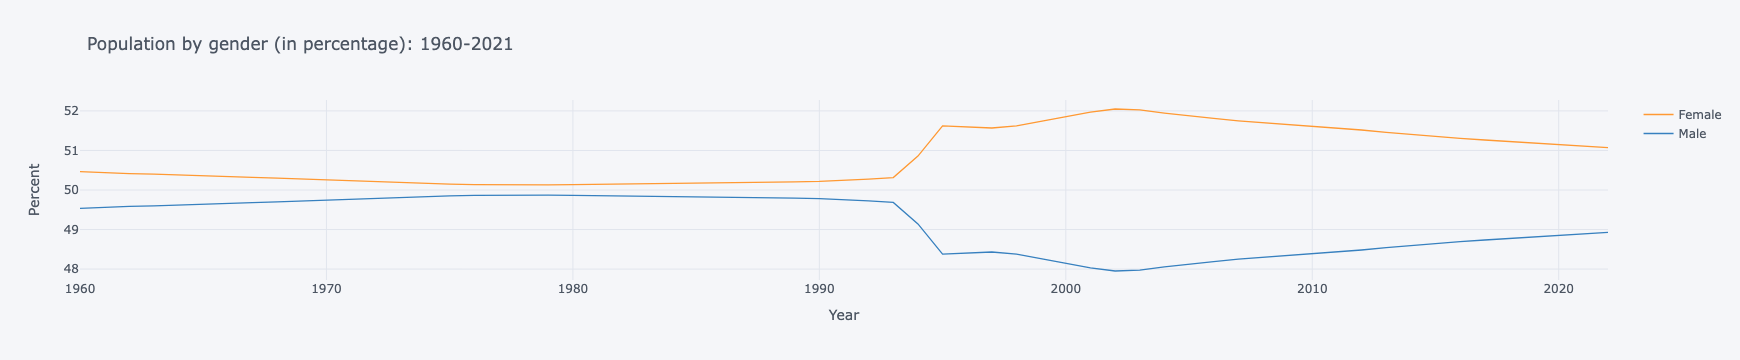

In [59]:
# Population over time as percent male and female.

# Two variables: Population % male, Population % female
variable_labels = {"SP.POP.TOTL.FE.ZS": "Female",
                   "SP.POP.TOTL.MA.ZS": "Male"}

# Set country to Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
rwanda_pop = wbdata.get_dataframe(variable_labels, country = Rwanda).squeeze()

# Date index is of type string; change to integers
rwanda_pop.index = rwanda_pop.index.astype(int)

# Print graph from 1960-2022
rwanda_pop.iplot(title="Population by gender (in percentage): 1960-2021",xTitle='Year',yTitle='Percent')

#### Mortality Rate per 1000 adults. <a name="mortality-rate-for-1000-adults"></a>

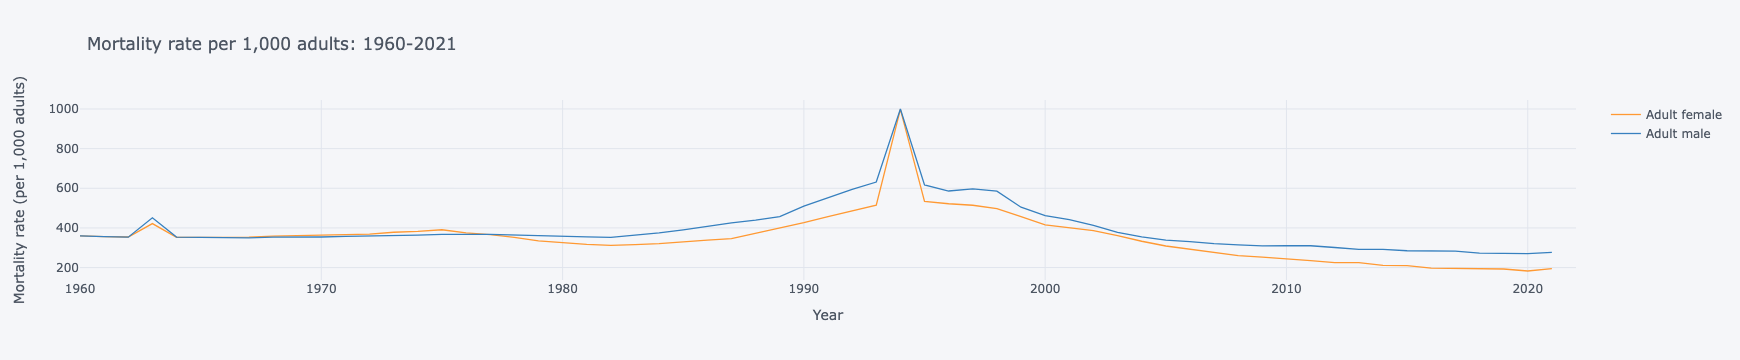

In [61]:
# Mortality rate per 1,000 adults.

# Two variables: Male mortality rate per 1,000 adults, female mortality rate per 1,000 adults
variable_labels = {"SP.DYN.AMRT.FE":"Adult female",
                   "SP.DYN.AMRT.MA": "Adult male"}

# Set country to Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
rwanda_pop = wbdata.get_dataframe(variable_labels, country = Rwanda).squeeze()

# Date index is of type string; change to integers
rwanda_pop.index = rwanda_pop.index.astype(int)

# Print graph from 1960-2022
rwanda_pop.iplot(title="Mortality rate per 1,000 adults: 1960-2021",xTitle='Year',yTitle='Mortality rate (per 1,000 adults)')

#### Crude Death Rate per 1000 People <a name="crude-death-rate-per-1000-people"></a>

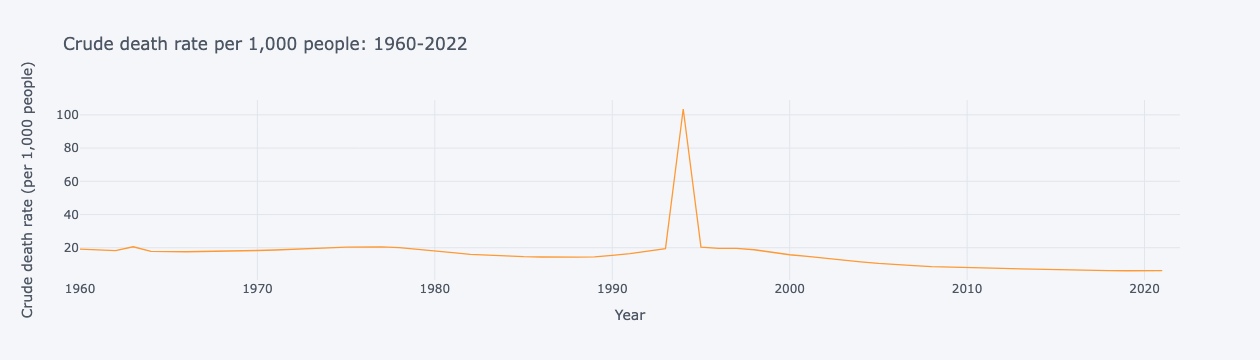

In [34]:
# Crude deah rate per 1,000 people.

# One variable: Crude death rate
variable_labels = {"SP.DYN.CDRT.IN": "Crude death rate"}

# Set country to Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
rwanda_deathrte = wbdata.get_dataframe(variable_labels, country = Rwanda).squeeze()

# Date index is of type string; change to integers
rwanda_deathrte.index = rwanda_pop.index.astype(int)

# Print graph from 1960-2022
rwanda_deathrte.iplot(title="Crude death rate per 1,000 people: 1960-2021",xTitle='Year',yTitle='Crude death rate (per 1,000 people)')

#### Net Migration in Rwanda <a name="net-migration-in-rwanda"></a>

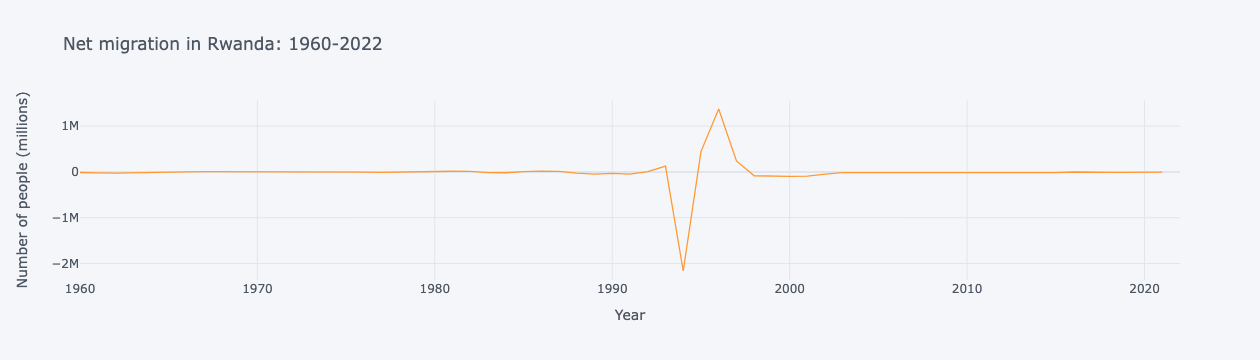

In [35]:
# Net migration (number of people migrating into the country - number of people migrating out).

# One variable: Net migration
variable_labels = {"SM.POP.NETM": "Net migration"}

# Set country to Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
rwanda_migration = wbdata.get_dataframe(variable_labels, country = Rwanda).squeeze()

# Date index is of type string; change to integers
rwanda_migration.index = rwanda_migration.index.astype(int)

# Print graph from 1960-2022
rwanda_migration.iplot(title="Net migration in Rwanda: 1960-2021",xTitle='Year',yTitle='Number of people (millions)')

#### Net Migration in Rwanda and Neighboring Countries <a name="net-migration-in-rwanda-and-neighboring-countries"></a>

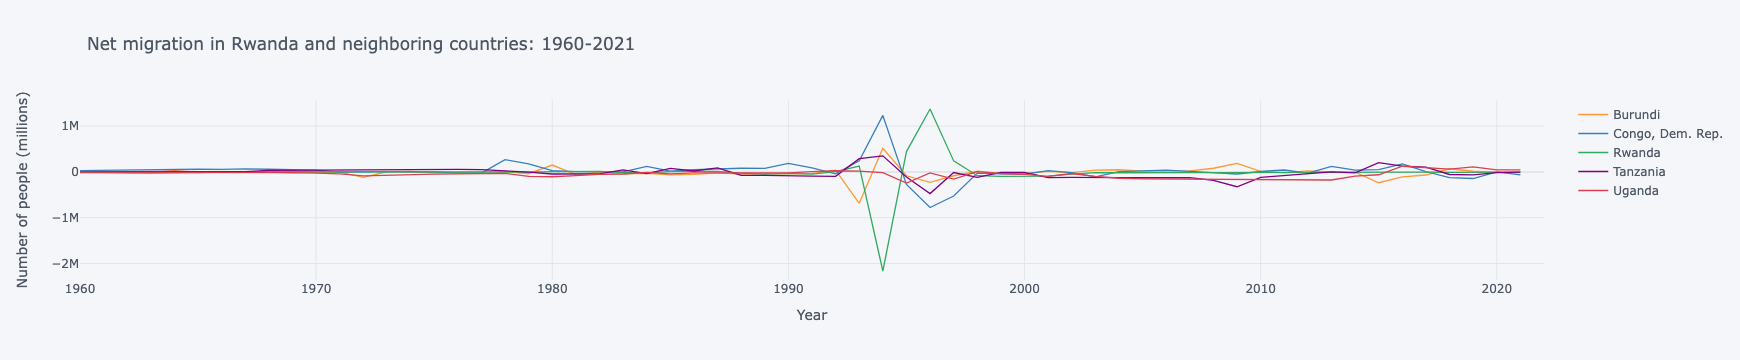

In [51]:
# Net migration in Rwanda and countries neighboring Rwanda.

# One variable: Net migration
variable_labels = {"SM.POP.NETM": "Net migration"}

# Four countries: Rwanda, Burundi, DRC, Tanzania
countries = {"RWA": "Rwanda",
             "BDI":"Burundi",
             "COD": "Democratic Republic of Congo",
             "TZA": "Tanzania",
             "UGA": "Uganda"}

# Get dataframe
migration = wbdata.get_dataframe(variable_labels, country = countries).squeeze()

#Unstack
migration = migration.unstack('country')

# Date index is of type string; change to integers
migration.index = migration.index.astype(int)

# Print graph from 1960-2022
migration.iplot(title="Net migration in Rwanda and neighboring countries: 1960-2021",xTitle='Year',yTitle='Number of people (millions)')

#### Net Migration in Neighboring Countries as Percentage of Total Population <a name="net-migration-in-neighboring-countries"></a>

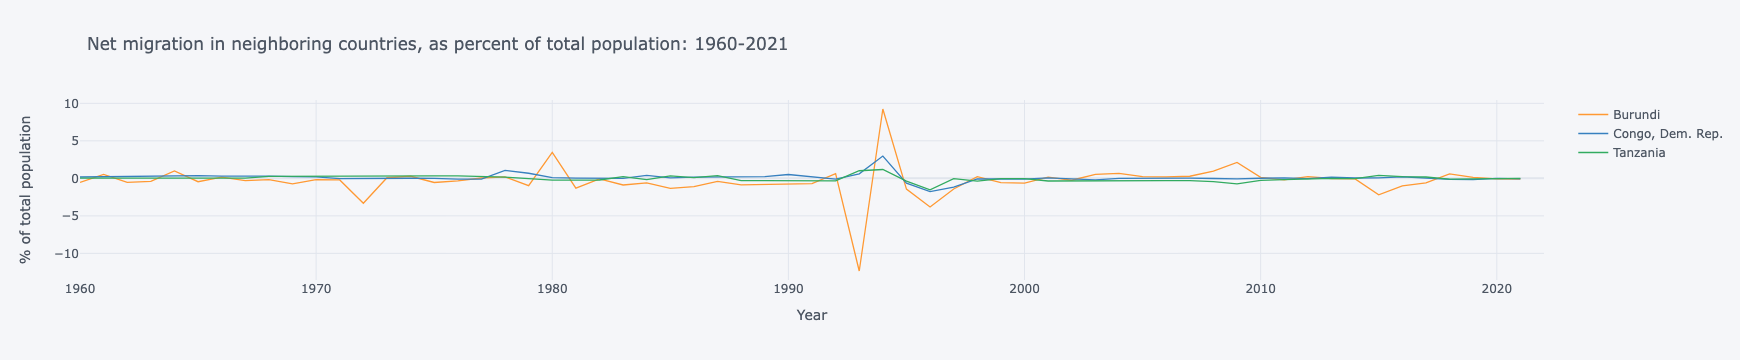

In [54]:
# Net migration of countries neighboring Rwanda as a percentage of total population.

# First variable: Net migration
variable_label = {"SM.POP.NETM": "Net migration"}

# Second variable: Total population
variable_label_2 = {"SP.POP.TOTL": "Total Population"}

# Three countries: Burundi, DRC, Tanzania
countries = {"BDI":"Burundi",
             "COD": "Democratic Republic of Congo",
             "TZA": "Tanzania"}

# Get Dataframe for net migration
df_migration = wbdata.get_dataframe(variable_label, country = countries).squeeze()
df_migration = df_migration.unstack('country')

# Get Dataframe for total population
df_totalpop = wbdata.get_dataframe(variable_label_2, country = countries).squeeze()
df_totalpop = df_totalpop.unstack('country')

# Divide dataframes to get net migration as a percentage of total population
migration_percent = df_migration.div(df_totalpop) * 100

# Date index is of type string; change to integers
migration_percent.index = migration_percent.index.astype(int)

# Print graph from 1960-2022
migration_percent.iplot(title="Net migration in neighboring countries, as percent of total population: 1960-2021",xTitle='Year',yTitle='% of total population')

#### Life Expectancy at Birth <a name="life-expectancy-at-birth"></a>

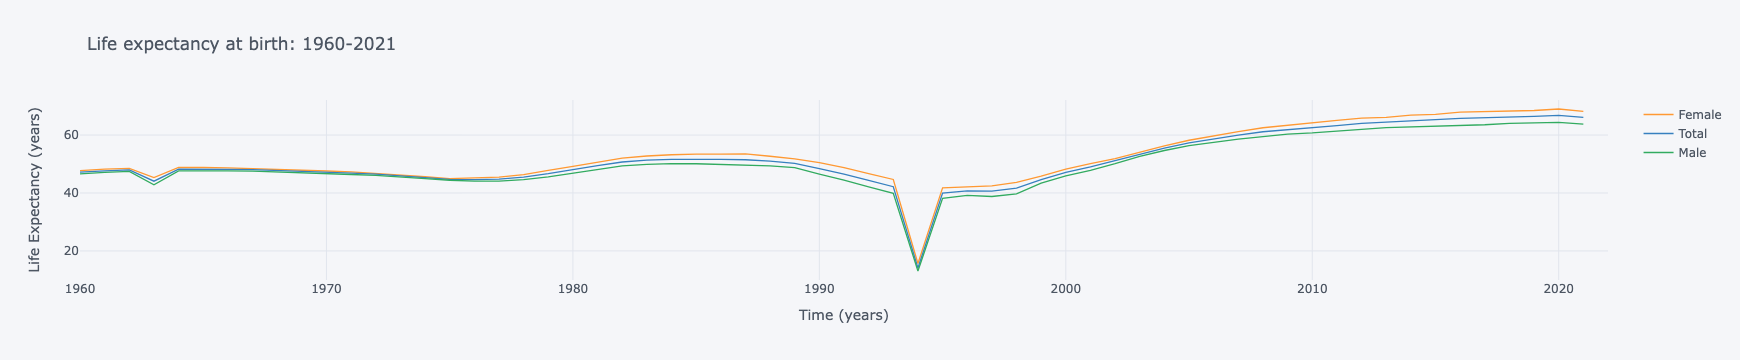

In [50]:
# Life expectancy at birth over time, with male and female.

# Three variables: Total life expectancy, Male life expectancy, Female life expectancy
variable_labels = {"SP.DYN.LE00.FE.IN": 'Female',
                   'SP.DYN.LE00.IN':    'Total',
                   'SP.DYN.LE00.MA.IN': 'Male'}

# Set country as Rwanda
Rwanda = {"RWA":"Rwanda"}

# Get dataframe
life_expectancy = wbdata.get_dataframe(variable_labels, country = Rwanda).squeeze()

# Date index is of type string; change to integers
life_expectancy.index = life_expectancy.index.astype(int)

# Print graph from 1960-2022
life_expectancy.iplot(title="Life expectancy at birth: 1960-2021",xTitle='Time (years)',yTitle='Life Expectancy (years)')

#### GDP Per Capita <a name="gdp-per-capita"></a>

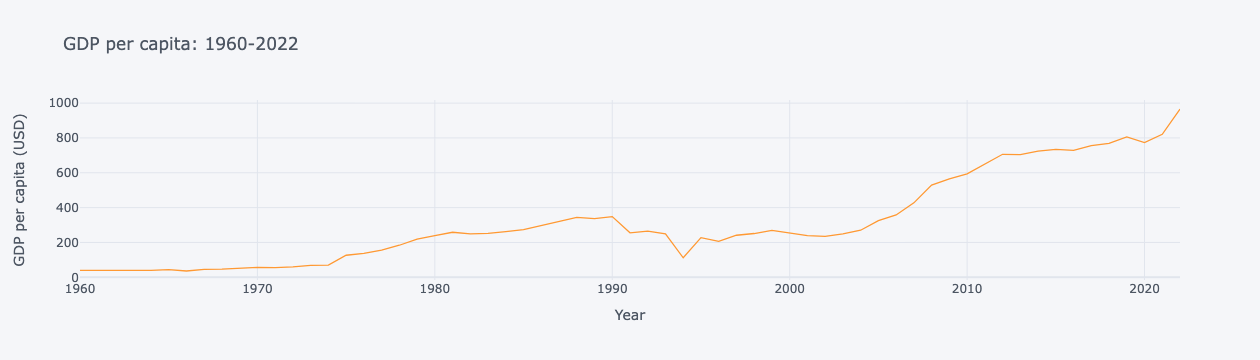

In [39]:
# GDP per capita over time.

# One variable: GDP per capita
variable_labels = {"NY.GDP.PCAP.CD": "GDP per capita"}

# Set country as Rwanda
Rwanda = {"RWA": "Rwanda"}

# Get dataframe
rwanda_gpc = wbdata.get_dataframe(variable_labels, country = Rwanda)

# Date index is of type string; change to integers
rwanda_gpc.index = rwanda_gpc.index.astype(int)

# Print graph from 1960-2022
rwanda_gpc.iplot(title="GDP per capita: 1960-2021",xTitle='Year',yTitle='GDP per capita (USD)')

#### Agriculture Productivity <a name="agriculture-productivity"></a>

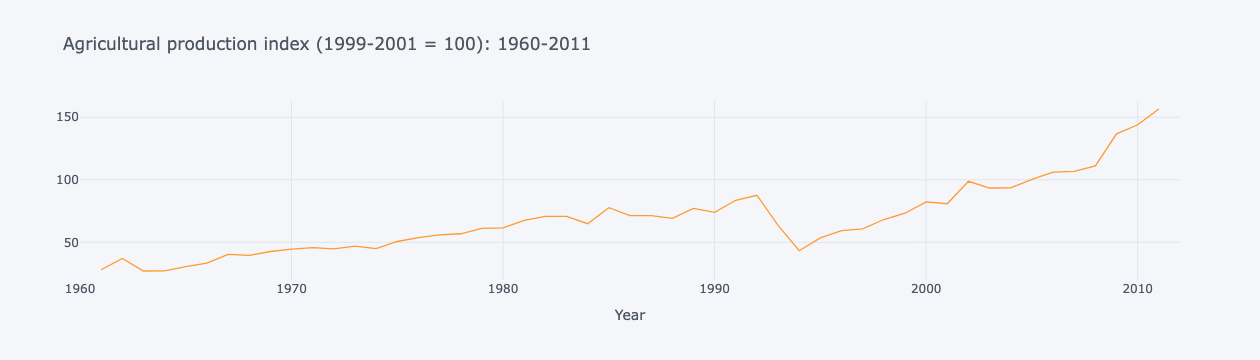

In [40]:
# Agricultural production index.

# One variable: Agricultural production index
variable_labels = {"AG.PRD.AGRI.XD": "Agricultural production index"}

# Set country as Rwanda
Rwanda = {"RWA": "Rwanda"}

# Get dataframe
rwanda_api = wbdata.get_dataframe(variable_labels, country = Rwanda)

# Date index is of type string; change to integers
rwanda_api.index = rwanda_api.index.astype(int)

# Print graph from 1960-2022
rwanda_api.iplot(title="Agricultural production index (1999-2001 = 100): 1960-2011",xTitle='Year')

## Unit Tests <a name="unit-tests"></a>
This section of Unit Testing double-verifies that all of our deliverable functions work properly.

In [41]:
# This unit test verifies that there were more than 10,000 albanian residents between the ages of 10-50 in the year 1990.

assert(population(1990, "all", [10, 50], "Albania") > 10000), "Error"

In [42]:
# This unit text verifies that there were more Cammbodian residents between the ages 5-15 than the ages 60-79 in the year 2000

assert(population(2000, "all", [5, 15], "Cambodia") > population(2000, "all", [60, 79], "Cambodia")), "Error"

In [43]:
# This unit test verifies that there were more Japanese citizens between the ages of 10 and 30 in the year 2010 than in the year 2012.

assert(population(2010, "all", [10, 30], "Japan") > population(2012, "all", [10, 30], "Japan")), "Error"

In [44]:
# This unit test verifies that there were more French residents between the ages 20-50 in the year 2019 than in the year 2020.

assert(population(2019, "all", [20, 50], "France") > population(2020, "all", [20, 50], "France")), "Error"

In [45]:
# This unit test verifies that there were more females than males in the world aged between 70-79 in the year 2000.

assert(population(2000, "males", [70, 79], "World") < population(2000, "females", [70, 79], "World")), "Error"